In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [3]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [830 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,798 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,069 kB]
Hit:13 https

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
import pandas as pd

ravdess_directory = "/content/drive/MyDrive/Dataset"
ravdess_directory_list = os.listdir(ravdess_directory)

file_emotion = []
file_path = []

for i in ravdess_directory_list:
    actor = os.listdir(os.path.join(ravdess_directory, i))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        if len(part) >= 3:  # Ensure that there are at least 3 parts
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(ravdess_directory, i, file))
        else:
            print(f"Issue with file: {file}. Skipping...")

# list to dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combining
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# int to emotion
ravdess_df['Emotions'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgusted', 8:'surprised'}, inplace=True)
ravdess_df.head()


Issue with file: Actor_04. Skipping...
Issue with file: Actor_01. Skipping...
Issue with file: Actor_03. Skipping...
Issue with file: Actor_02. Skipping...
Issue with file: Actor_05. Skipping...
Issue with file: Actor_06. Skipping...
Issue with file: Actor_09. Skipping...
Issue with file: Actor_07. Skipping...
Issue with file: Actor_08. Skipping...
Issue with file: Actor_10. Skipping...
Issue with file: Actor_12. Skipping...
Issue with file: Actor_13. Skipping...
Issue with file: Actor_14. Skipping...
Issue with file: Actor_11. Skipping...
Issue with file: Actor_15. Skipping...
Issue with file: Actor_19. Skipping...
Issue with file: Actor_16. Skipping...
Issue with file: Actor_20. Skipping...
Issue with file: Actor_17. Skipping...
Issue with file: Actor_18. Skipping...
Issue with file: Actor_22. Skipping...
Issue with file: Actor_23. Skipping...
Issue with file: Actor_24. Skipping...
Issue with file: Actor_21. Skipping...


,Emotions,Path
0,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
1,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
2,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
3,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
4,calm,/content/drive/MyDrive/Dataset/Actor_10/03-01-...


In [6]:
ravdess_df["Emotions"].value_counts()

Emotions
calm         192
happy        192
sad          192
angry        192
fear         192
disgusted    192
surprised    192
neutral       96
Name: count, dtype: int64

In [7]:
import pandas as pd

# Assuming Savee_df is your DataFrame containing the Savee dataset
data_path_ravdess = ravdess_df.copy()  # Make a copy of Savee_df

data_path_ravdess.to_csv("ravdess_data.csv", index=False)  # Save Savee dataset to CSV
data_path_ravdess.head()  # Display the first few rows of the Savee dataset


,Emotions,Path
0,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
1,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
2,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
3,neutral,/content/drive/MyDrive/Dataset/Actor_10/03-01-...
4,calm,/content/drive/MyDrive/Dataset/Actor_10/03-01-...


In [8]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [9]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    return audio

In [10]:
import timeit
from tqdm import tqdm
import librosa

start = timeit.default_timer()
X, Y = [], []

# Iterate over the data paths
for path, emotion, index in tqdm(zip(data_path_ravdess.Path, data_path_ravdess.Emotions, range(data_path_ravdess.Path.shape[0]))):
    # Correcting the path format
    path = path.replace("ALL", "ALL/")

    # Load audio file
    audio_data, sr = librosa.load(path)

    # Calculate RMS of the signal
    rms_value = librosa.feature.rms(y=audio_data)

    # Append RMS value to X
    X.append(rms_value)

    # Append emotion label to Y
    Y.append(emotion)

    if index % 500 == 0:
        print(f'{index} audio has been processed')

print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)


1it [00:18, 18.40s/it]

0 audio has been processed


501it [04:02,  2.05it/s]

500 audio has been processed


1001it [07:46,  2.04it/s]

1000 audio has been processed


1440it [11:04,  2.17it/s]

Done
Time:  664.216732958


In [11]:
len(X), len(Y), data_path_ravdess.Path.shape

(1440, 1440, (1440,))

In [12]:
import numpy as np
import pandas as pd

# Find the maximum length of arrays along axis 1
max_length = max(arr.shape[1] for arr in X)

# Pad the arrays in X with zeros to match the maximum length
X_padded = [np.pad(arr, ((0, 0), (0, max_length - arr.shape[1])), mode='constant', constant_values=0) for arr in X]

# Concatenate the padded arrays into a single 2D array
X_concatenated = np.concatenate(X_padded, axis=0)

# Create DataFrame with the concatenated features
Emotions = pd.DataFrame(X_concatenated)

# Add emotion labels as a column
Emotions['Emotions'] = Y

# Save DataFrame to CSV
Emotions.to_csv('ravdess_data.csv', index=False)

# Display DataFrame
Emotions.head()


,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,Emotions
0,0.000135,0.000165,0.000182,0.000178,0.000174,0.000170,0.000175,0.000180,0.000167,0.000164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1,0.000065,0.000083,0.000102,0.000285,0.000305,0.000302,0.000297,0.000123,0.000058,0.000073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
2,0.000029,0.000031,0.000044,0.000051,0.000051,0.000053,0.000048,0.000046,0.000045,0.000049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
3,0.000028,0.000041,0.000056,0.000060,0.000062,0.000059,0.000050,0.000047,0.000045,0.000045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
4,0.000181,0.000227,0.000255,0.000248,0.000229,0.000206,0.000205,0.000207,0.000218,0.000240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,calm


In [13]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape



0           False
1           False
2           False
3           False
4           False
            ...  
224         False
225         False
226         False
227         False
Emotions    False
Length: 229, dtype: bool


(1440, 229)

In [14]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values



#TESS Strats now

In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [16]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/TESS Toronto emotional speech set data'):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    # print(filename)
    label = filename.split('_')[-1]
    # print(label)
    label = label.split('.')[0]
    labels.append(label.lower())
print('Dataset is Loaded')


Dataset is Loaded


In [17]:
##create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/TESS Toronto emotional ...,angry
1,/content/drive/MyDrive/TESS Toronto emotional ...,angry
2,/content/drive/MyDrive/TESS Toronto emotional ...,angry
3,/content/drive/MyDrive/TESS Toronto emotional ...,angry
4,/content/drive/MyDrive/TESS Toronto emotional ...,angry


In [18]:
def extract_mfcc(filename):
  y, sr = librosa.load(filename, duration=3, offset=0.5)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
  return mfcc

In [19]:
extract_mfcc(df['speech'][0])

array([-3.5403134e+02,  5.3507679e+01, -6.6787190e+00,  3.2752794e-01,
       -2.9446516e+01,  6.3578453e+00,  4.1013818e+00, -1.9642618e+01,
       -2.0833244e+00,  1.7922984e+00, -1.4493582e+01,  9.1661568e+00,
       -9.8589067e+00,  5.4053144e+00,  1.3328303e-01, -8.5065470e+00,
        1.5562576e+00,  1.3521976e+00, -7.5838165e+00,  3.5279758e+00,
       -2.3671410e+00, -2.6570652e+00, -2.8023188e+00, -1.2182224e+00,
       -3.4724441e-01,  7.5056272e+00,  1.0552016e+01,  1.1414539e+01,
        1.1704172e+01,  7.9567084e+00,  8.4932804e-01,  2.3558936e+00,
       -2.5685732e+00,  2.7504137e+00,  1.6989278e+00, -1.0697829e+00,
       -2.2785194e+00, -2.8954208e+00,  1.9441764e+00,  3.8444636e+00],
      dtype=float32)

In [20]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [21]:
  X_mfcc

0       [-354.03134, 53.50768, -6.678719, 0.32752794, ...
1       [-329.51895, 22.86458, 1.3039654, 8.73677, -19...
2       [-316.56366, 109.3681, -7.4545336, -4.5025764,...
3       [-323.86, 70.17526, -5.0372443, -14.311751, -3...
4       [-339.3216, 50.24379, -21.820583, 13.099628, -...
                              ...                        
5595    [-428.04822, 57.957573, 1.2415637, 37.944313, ...
5596    [-374.48767, 72.036545, 12.567796, 18.573978, ...
5597    [-409.49863, 89.658905, -4.345877, 25.175097, ...
5598    [-420.40222, 80.02803, 6.293351, 32.179897, 2....
5599    [-391.8462, 100.0138, -3.7448769, 24.643173, 1...
Name: speech, Length: 5600, dtype: object

In [22]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

#Splitting of the datasets

In [24]:
# Define X_train and y_train
X_train = Emotions.iloc[:, :-1].values
y_train = Emotions['Emotions'].values


In [25]:
# Define X_test and y_test
X_test = X
y_test = y.toarray()


#Model training

In [26]:
print(X_train.dtype)
print(y_train.dtype)


float32
object


In [27]:
print(set(y_train))


{'fear', 'happy', 'surprised', 'angry', 'calm', 'neutral', 'disgusted', 'sad'}


In [28]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)


In [29]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder()

# Fit and transform the target variable
y_train_encoded = onehot_encoder.fit_transform(y_train.reshape(-1, 1))

# Convert sparse matrix to array
y_train_encoded = y_train_encoded.toarray()

# Now y_train_encoded should be in one-hot encoded format


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = 8
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)

model = tf.keras.Sequential([
    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),

    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),

    Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_one_hot,
                    epochs=50, batch_size=64, validation_split=0.5, verbose=1)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_91 (Conv1D)          (None, 228, 512)          3072      
                                                                 
 batch_normalization_96 (Ba  (None, 228, 512)          2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_91 (MaxPooli  (None, 114, 512)          0         
 ng1D)                                                           
                                                                 
 conv1d_92 (Conv1D)          (None, 114, 512)          1311232   
                                                                 
 batch_normalization_97 (Ba  (None, 114, 512)          2048      
 tchNormalization)                                               
                                                     

In [130]:
from tensorflow.keras.utils import to_categorical

# Assuming y_train contains your integer labels
num_classes = 8  # Adjust this based on the number of classes in your dataset

# Subtract 1 from labels to ensure they start from 0
y_train_adjusted = y_train - 1

# Convert adjusted labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_adjusted, num_classes=num_classes)


In [132]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding for test data
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


In [133]:
# Evaluate the model on test data
accuracy = model.evaluate(X_test, y_test, verbose=1)

# Display accuracy
print("Test Accuracy:", accuracy[1])


175/175 [==============================] - 1s 5ms/step - loss: 2.7310 - accuracy: 0.1400
Test Accuracy: 0.14000000059604645


In [77]:
print(X_train.shape)

(1440, 228)


In [138]:
y_pred = model.predict(X_test)


175/175 [==============================] - 1s 6ms/step


In [148]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

# # Generate confusion matrix
# print("Confusion Matrix:")
# print(confusion_matrix(y_test_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.85      0.75      0.80      4800
           2       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.64      5600
   macro avg       0.21      0.19      0.20      5600
weighted avg       0.73      0.64      0.68      5600



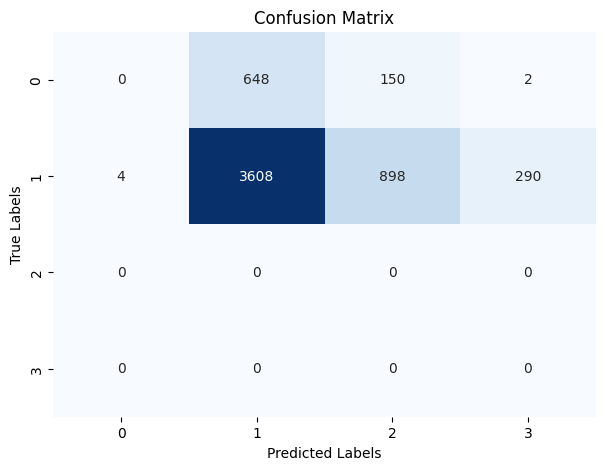

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


#Final